# Partial adaption in progress from FACS.py

In [10]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib as mpl
import time
import inspect
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as mplPath
import matplotlib.cm as cm
import matplotlib.patches as patches
from scipy import stats
from scipy.spatial import distance
import math
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import NMF, non_negative_factorization
from sklearn.neighbors import KernelDensity
from scipy import interpolate
from pathlib import Path

from fluor_gating_util import ScatterSelectorGating
import ipywidgets as widgets
from IPython.display import display

from bsccm import BSCCM
from demixing_util import *

bsccm = BSCCM(str(Path.home()) + '/BSCCM_local/BSCCM/')
dataframe_saving_fullpath = str(Path.home()) + '/BSCCM_local/BSCCM/BSCCM_surface_markers.csv'
# For exporting figures
export_dir = '/home/henry/leukosight_data/figures/demixing'

# channel_names = ['BV421', 'BV510', 'BV570', 'BV605', 'BV650', 'BV711']
# markers = {'BV421': 'CD123', 'BV510': 'CD3/CD19/CD56', 'BV570': 'HLA-DR', 'BV605': 'CD45',
#            'BV650': 'CD14', 'BV711':'CD16'}
# markers = ['CD123', 'CD3', 'CD19', 'CD56', 'HLA-DR', 'CD45', 'CD14', 'CD16']


channels = ['Fluor_426-446_shading_corrected', 
       'Fluor_500-550_shading_corrected', 
       'Fluor_550-570_shading_corrected', 
       'Fluor_585-625_shading_corrected', 
       'Fluor_627-673_shading_corrected', 
       'Fluor_690-_shading_corrected']

selections = ['selection_example_CD123_positive_cells',
            'selection_example_CD3_positive_cells',
            'selection_example_HLA-DR_positive_cells',
            'selection_example_CD45_positive_cells',
            'selection_example_CD14_positive_cells',
            'selection_example_CD16_positive_cells',]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Unmixing matrix and backgrounds

In [18]:
single_stain_spectra = [get_fluor_spectrum(selection, bsccm, channels)
                     for selection in selections]
#fluors by channels
single_stain_spectra = np.stack(single_stain_spectra, axis=0)
#normalize each fluor
single_stain_spectra = single_stain_spectra / np.linalg.norm(single_stain_spectra, axis=1)[:, None]

indices = bsccm.get_indices(antibodies='CD45', batch=0)
data = bsccm.surface_marker_dataframe.loc[indices, channels].to_numpy()

#TODO: do globally over all data
#nnmf requires all positive
data -= (np.min(data, axis = 0) - 1)

In [19]:
marked_mask = get_marked_mask(selections[3], bsccm, channels)

In [13]:
fig, ax = plt.subplots()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
import jax.numpy as jnp
from jax import grad, value_and_grad

def forward_model(unmixed, spectra, target):
    
    mixed = jnp.dot(unmixed, spectra)
    loss = jnp.sum((target - mixed)**2)
    
    return loss

val_grad_fn = value_and_grad(forward_model, 0)


target = jnp.array(data)
unmixed = jnp.zeros_like(target)
spectra = jnp.array(single_stain_spectra)


lr = 1e-2
loss_history = []
for i in range(10000):
    
    loss, grad = val_grad_fn(unmixed, spectra, data)
    unmixed -= lr * grad
    #enforce constraint
    unmixed = unmixed * jnp.logical_not(unmixed < 0)
    
    print('{}: {}        \r'.format(i, loss), end='')
    loss_history.append(loss)
    
    if i % 100 == 0:
        show_axes = (2, 3)
        ax.clear()
        ax.scatter(unmixed[np.logical_not(marked_mask), show_axes[0]],
                   unmixed[np.logical_not(marked_mask), show_axes[1]], c='k')
        ax.scatter(unmixed[marked_mask, show_axes[0]], 
                   unmixed[marked_mask, show_axes[1]], c='r')
        fig.canvas.draw()
    


KeyboardInterrupt: 

In [ ]:
def pltsin(ax, colors=['b']):
    
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)


In [67]:
use_stains = np.array([1])
normalize = False
multipliers = None

# manually set some to 0 if you know the fluor was not present
if use_stains == 'all':
    spectra = stain_basis.T
elif use_stains == 'unstained':
    spectra = np.zeros((0, 6))
else:
    spectra = stain_basis[:, use_stains]

stacked_spectra = np.copy(spectra)

 #nomarlize all spectra
if normalize:
    stacked_spectra /= np.linalg.norm(stacked_spectra, axis=1)[:, None]
    
#differntial multiplication of spectra to bias solutions toward particular outputs
if multipliers is not None: 
    if use_stains == 'all':
        stacked_spectra = stacked_spectra * multipliers[:stacked_spectra.shape[0], None]
    elif use_stains == 'unstained':
        stacked_spectra = stacked_spectra * multipliers[-2:, None]
    else :
        stacked_spectra = stacked_spectra * multipliers[[use_stains, -2, -1], None]  


data += 1e-10
W, H, n_iter = non_negative_factorization(data, H=stacked_spectra, n_components=stacked_spectra.shape[0],  
                                init=None, update_H=False, max_iter=200000, 
                                      regularization='transformation')


if multipliers is not None:
    if use_stains == 'all':
        W *= multipliers[None, :W.shape[1]]
    elif use_stains == 'unstained':
        W *= multipliers[None, -2:]
    else :
        W *= multipliers[None, [use_stains, -2, -1]]


# unpack solution into expected format
if use_stains == 'all':
    unmixed = W
else:
    empty = np.stack(6 * [np.zeros_like(W[:, 0])], axis=1)
    if use_stains != 'unstained':
        #single stain mode
        empty[:, use_stains] = W[:, 0]
        unmixed = np.concatenate([empty, W[:, 1:]], axis=1)
    else:
        #unstained mode
        unmixed = np.concatenate([empty, W], axis=1)

# unmixed += np.exp(min_max[0])
# unmixed = np.log(unmixed)

<ipython-input-67-e301a42cbe81>:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if use_stains == 'all':
<ipython-input-67-e301a42cbe81>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif use_stains == 'unstained':


ValueError: Array with wrong shape passed to NMF (input H). Expected (6, 6), but got (6, 1) 

In [ ]:
def do_nnmf(data, use_stains, stain_basis, min_max, multipliers=None,
            init='random', autofluor=None, normalize=False, **kwargs):
    
    # manually ste some to 0 if you know the fluor was not present
    if use_stains == 'all':
        spectra = stain_basis.T
    elif use_stains == 'unstained':
        spectra = np.zeros((0, 6))
    else:
        spectra = stain_basis[:, use_stains][None,:]
    
    spectra = [spectra]
    
     #nomarlize all spectra
    if normalize:
        stacked_spectra /= np.linalg.norm(stacked_spectra, axis=1)[:, None]
    #differntial multiplication of spectra to bias solutions toward particular outputs
    if multipliers is not None: 
        if use_stains == 'all':
            stacked_spectra = stacked_spectra * multipliers[:stacked_spectra.shape[0], None]
        elif use_stains == 'unstained':
            stacked_spectra = stacked_spectra * multipliers[-2:, None]
        else :
            stacked_spectra = stacked_spectra * multipliers[[use_stains, -2, -1], None]  
        
        
    relevant_args = {key: kwargs[key] for key in kwargs.keys() if key in
                     list(inspect.signature(non_negative_factorization).parameters)}

    data += 1e-10
    W, H, n_iter = non_negative_factorization(data, H=stacked_spectra, n_components=stacked_spectra.shape[0],  
                                    init=init, update_H=False, max_iter=200000, 
                                          regularization='transformation', **relevant_args)
    
    
    if multipliers is not None:
        if use_stains == 'all':
            W *= multipliers[None, :W.shape[1]]
        elif use_stains == 'unstained':
            W *= multipliers[None, -2:]
        else :
            W *= multipliers[None, [use_stains, -2, -1]]
            
    
    if use_stains == 'all':
        unmixed = W
    else:
        empty = np.stack(6 * [np.zeros_like(W[:, 0])], axis=1)
        if use_stains != 'unstained':
            #single stain mode
            empty[:, use_stains] = W[:, 0]
            unmixed = np.concatenate([empty, W[:, 1:]], axis=1)
        else:
            #unstained mode
            unmixed = np.concatenate([empty, W], axis=1)
    
    unmixed += np.exp(min_max[0])
    unmixed = np.log(unmixed)
    return unmixed


## Unmixing functions

In [3]:

def compute_histograms(unmixed_datasets, num_bins=60, min_max=(np.log(1e3), 17)):
    hists = {}
    for dataset_name in unmixed_datasets.keys():
        dataset_hists = []
        for stain_index in range(unmixed_datasets[dataset_name].shape[1]):
            hist, bin_edges = np.histogram(unmixed_datasets[dataset_name][:, stain_index],
                                          num_bins, min_max, density=True)
            dataset_hists.append(hist)
        hists[dataset_name] = np.stack(dataset_hists)
    return hists, bin_edges

def plot_hists(histograms, channel_names, show_vec=np.arange(8), **kwargs):
    fig, ax = plt.subplots(len(histograms), len(show_vec), figsize=(15, 12))

    for i, name in enumerate(histograms.keys()):
        ax_row = ax[i]
        for j in range(len(show_vec)):
            if i == 0:
                ax_row[j].set_title((channel_names + ['autofluor1', 'auotfluor2'])[show_vec[j]])
            if j == 0:
                ax_row[j].set_ylabel(name)
            else:
                ax_row[j].get_yaxis().set_visible(False)

            
            ax_row[j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, histograms[name][show_vec[j]], 
                          width=bin_edges[1] - bin_edges[0])
            ax_row[j].set_yscale('log')
            ax_row[j].set_ylim([1e-4, 1.6])
            
def prepare_dataset(dataset_index, dataframe, channel_names, dataset_backgrounds, slidescan_db, **kwargs):
    dataset_data = dataframe[dataframe['dataset_index'].to_numpy() == dataset_index][channel_names].to_numpy()
    dataset_data -= dataset_backgrounds[dataset_index][None, :]
    dataset_data[dataset_data < 0] = 0
    stain_name = slidescan_db.loc[dataset_index]['Stain']
    marker_name = slidescan_db.loc[dataset_index]['Marker']
    stain_spectrum_index = channel_names.index(stain_name) if stain_name in channel_names else stain_name
    return dataset_data, stain_name, marker_name, stain_spectrum_index

def invert_dataset(dataset_index, min_max=(np.log(1e3), 17), **kwargs):
    dataset_data, stain_name, marker_name, stain_spectrum_index = prepare_dataset(dataset_index, **kwargs)
    if 'inversion_model' in kwargs:
        if kwargs['inversion_model'] == 0:
            stain_spectrum_index = 'unstained'
        elif kwargs['inversion_model'] == 6:
            stain_spectrum_index = 'all'
        else:
            pass #its equal to the spectra index
    
    return do_nnmf(dataset_data, stain_spectrum_index, min_max=min_max, **kwargs)

def single_stain_invert_and_score(multiplier_batch, dataset_index, unstained_unmixed, min_max=(np.log(1e3), 17),
                                batch_index = 1,  **kwargs):
    dataset_data, stain_name, marker_name, stain_spectrum_index = prepare_dataset(dataset_index, **kwargs)

    scores = []
    for multipliers in multiplier_batch:   
        single_stain_unmixed = do_nnmf(data=dataset_data, use_stains=stain_spectrum_index,
                                       multipliers=multipliers, min_max=min_max, **kwargs)
        
        #look only at af distribution
        dists = dist_dist(unstained_unmixed[:, 6], single_stain_unmixed[:, 6]) + \
                dist_dist(unstained_unmixed[:, 7], single_stain_unmixed[:, 7])
        scores.append(np.sum(dists)) 
    return np.array(scores)

# Raw histograms with no regularization

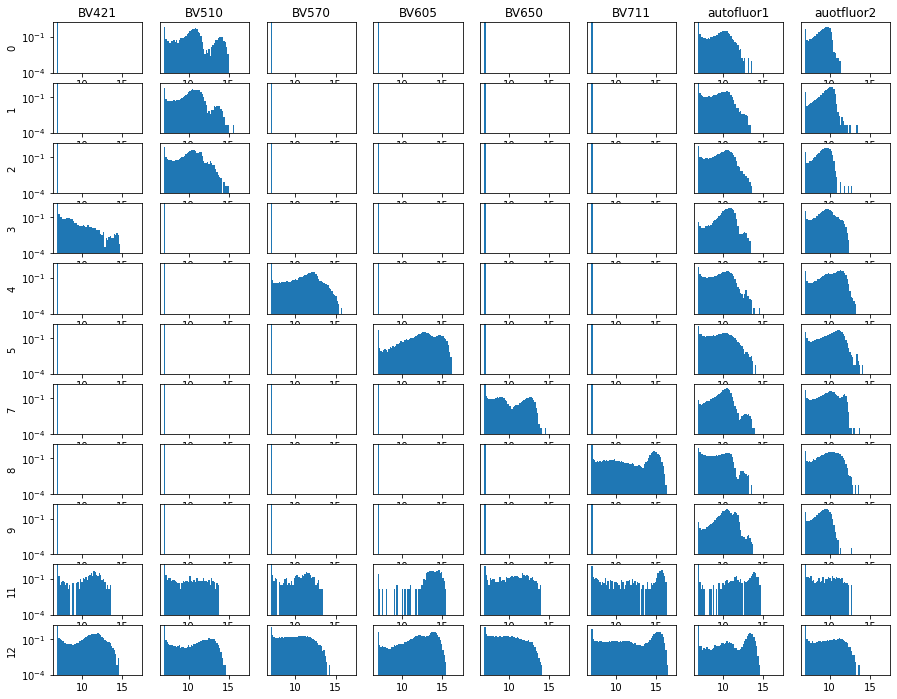

In [4]:
##compute histograms for all with no regularization
use_batch = 1
min_max = (np.log(1e3), 17)
num_bins = 60

to_use = all_data['slidescan_db'].query('Batch == {}'.format(use_batch))
dataset_indices = to_use['Index'].to_list()

unmixed_datasets = {}
for ds_index in dataset_indices:

#     unmixed_datasets[all_data['slidescan_db'].loc[ds_index]['Marker'] + '  ' + str(ds_index)] = \
    unmixed_datasets[str(ds_index)] = \
            invert_dataset(ds_index, multipliers=np.ones(8), alpha=0, solver='mu', 
                           init='nnsvda', beta_loss='kullback-leibler', normalize=True, autofluor=2, **all_data)
#     ‘frobenius’, ‘kullback-leibler’, ‘itakura-saito’

histograms, bin_edges = compute_histograms(unmixed_datasets)
plot_hists(histograms, **all_data)

[0.         1.         0.         0.         0.         0.
 7.88046282 0.45203537] (12, 21)
[ 0.          1.          0.          0.          0.          0.
 10.82636734  1.1721023 ] (15, 22)
[1.         0.         0.         0.         0.         0.
 2.21221629 0.85316785] (14, 17)
[0.         0.         1.         0.         0.         0.
 2.21221629 0.45203537] (12, 17)
[0.         0.         0.         1.         0.         0.
 0.45203537 0.23950266] (10, 12)
[0.         0.         0.         0.         1.         0.
 1.61026203 0.62101694] (13, 16)
[0.         0.         0.         0.         0.         1.
 0.45203537 0.17433288] (9, 12)
[0.         0.         0.         0.         0.         1.
 0.32903446 0.17433288] (9, 11)
[0.         0.         0.         0.         1.         0.
 2.21221629 0.85316785] (14, 17)
[0.         0.         0.         1.         0.         0.
 0.62101694 0.32903446] (11, 13)
[0.         0.         1.         0.         0.         0.
 0.62101694 0.3

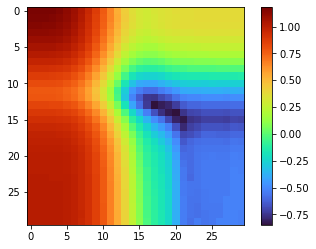

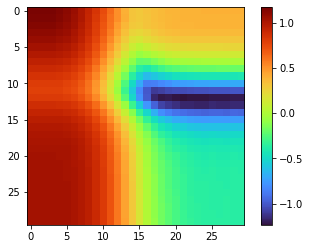

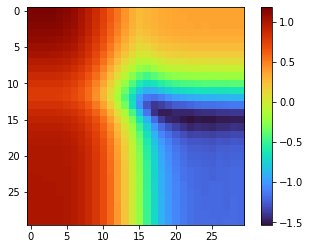

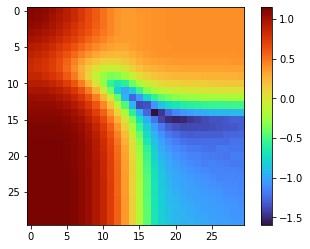

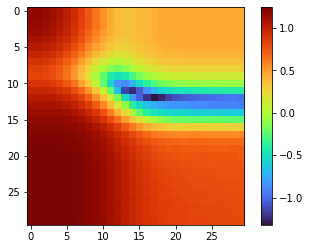

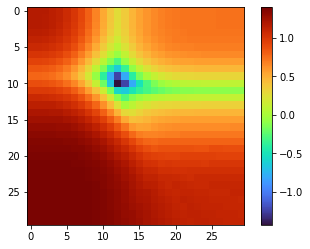

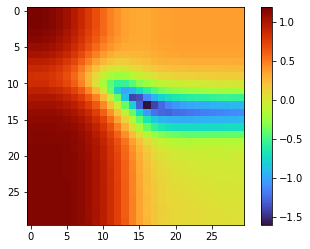

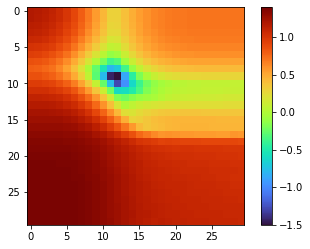

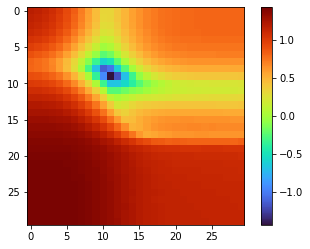

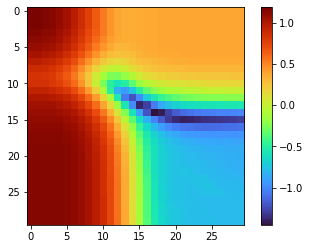

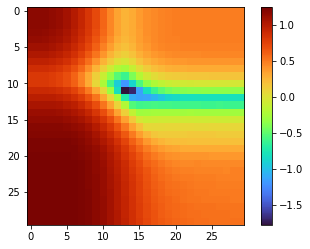

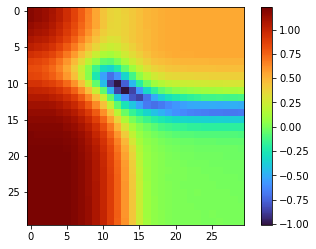

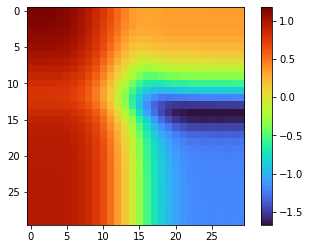

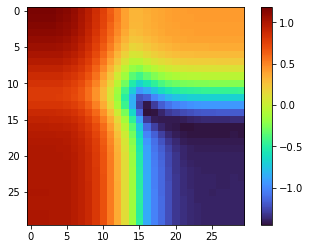

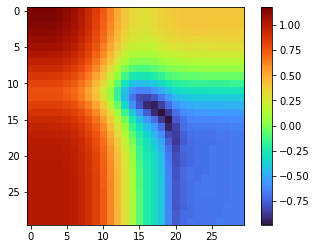

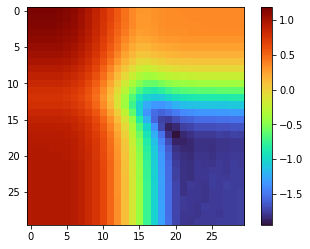

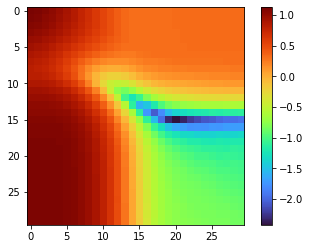

In [5]:
def optimize_single_stain_multipliers(dataset_index, slidescan_db, channel_names, min_max=(np.log(1e3), 17), **kwargs):
    
    stain_name = slidescan_db.query('(Index == {})'.format(dataset_index))['Stain'].to_list()[0]
    channel_index = channel_names.index(stain_name)
    
    af_mult = np.logspace(-2, 2, 30)
    af2_mult = np.logspace(-2, 2, 30)
    af_grid, af2_grid = np.meshgrid(af_mult, af2_mult)

    multipliers = np.stack(6 * [np.zeros_like(af_grid)] + [af_grid, af2_grid], axis=-1)
    multipliers[..., channel_index] =  np.ones_like(af_grid)

    flattened_multipliers = np.reshape(multipliers, [-1, multipliers.shape[-1]])
    multiplier_batches = np.split(flattened_multipliers, 60)
    unstained_unmixed = invert_dataset(dataset_index=9, multiplier=np.ones(8),  alpha=0,
                                       solver='mu',  init='nnsvda', beta_loss='kullback-leibler', 
                                       normalize=True, autofluor=2, **all_data)

    scores = []
    for batch in multiplier_batches: 
        scores.append(single_stain_invert_and_score(batch, dataset_index, unstained_unmixed, 
                                       alpha=1e-5, solver='mu', init='nnsvda', beta_loss='kullback-leibler', 
                                       normalize=True, autofluor=2, **all_data))

#     scores = Parallel(n_jobs=50, prefer='processes', verbose=0)(
#         delayed(single_stain_invert_and_score)(batch, dataset_index, unstained_unmixed, 
#                                        alpha=1e-5, solver='mu', init='nnsvda', beta_loss='kullback-leibler', 
#                                        normalize=True, autofluor=2, **all_data) for batch in multiplier_batches)

    distance_scores = np.reshape(np.concatenate(scores), af_grid.shape)

    ind = np.unravel_index(np.argmin(distance_scores), distance_scores.shape)
    best_multiplier = np.array([0, 0, 0, 0, 0, 0, af_grid[ind], af2_grid[ind]])
    best_multiplier[channel_index] = 1
    
    print(best_multiplier, ind)
    plt.figure()
    plt.imshow(np.log(distance_scores) , cmap='turbo')
    plt.colorbar()
    
    return best_multiplier
    
single_stain_multipliers = {}
ds_indices = all_data['slidescan_db'].query('((Batch == 2) or (Batch == 1)) and (Stain != \'unstained\')'' \
                                   and (Stain != \'all\')')['Index'].to_list()
all_data['slidescan_db']['Index'].to_list()
for ds_index in ds_indices:
    print('{}\r'.format(ds_index), end='')
    single_stain_multipliers[ds_index] = optimize_single_stain_multipliers(dataset_index=ds_index, 
               init='nndsvda', beta_loss='kullback-leibler', alpha=1e-5, l1_ratio=1.,  normalize=True,                                                          
                                            solver='mu', **all_data)

## Single stain reconstructions with optimized params

/home/henry/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


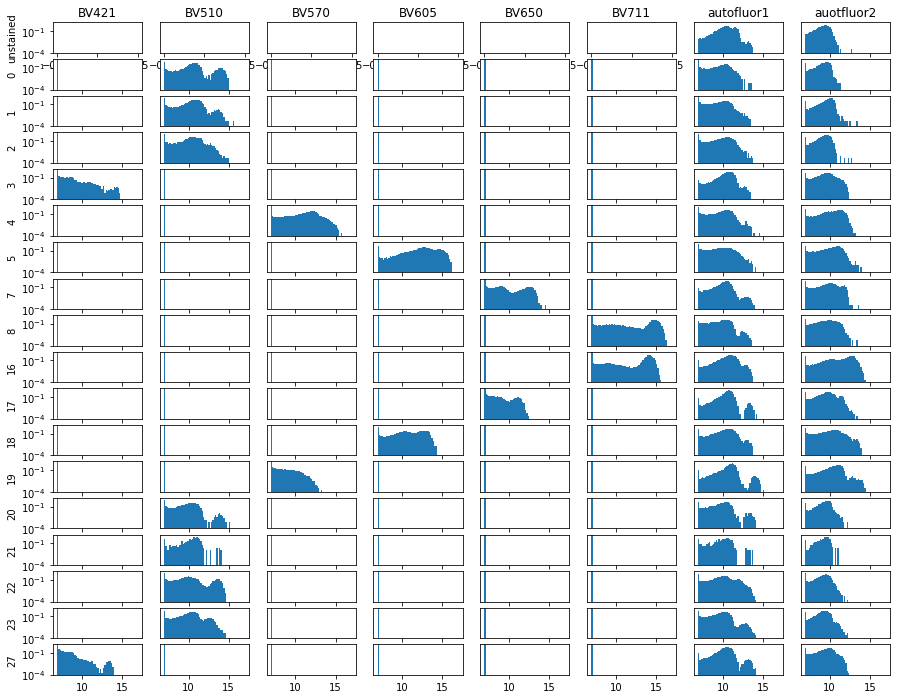

In [6]:
unmixed_datasets = {}
unmixed_datasets['unstained'] = invert_dataset(9, np.ones(8), init='nnsvda', solver='mu',
            beta_loss='kullback-leibler', alpha=0, l1_ratio=1., autofluor=2, normalize=True, **all_data)

for dataset_index in single_stain_multipliers.keys():    
    unmixed_datasets['{}'.format(dataset_index)] = invert_dataset(
            dataset_index,  init='nndsvda',  solver='mu',
        multipliers=single_stain_multipliers[dataset_index],
            beta_loss='kullback-leibler', alpha=1e-5, l1_ratio=1., autofluor=2, normalize=True,                                                          
                **all_data)

histograms_ss_optimized, bin_edges = compute_histograms(unmixed_datasets)
plot_hists(histograms_ss_optimized, show_vec=[0,1,2,3,4,5,6,7], **all_data)

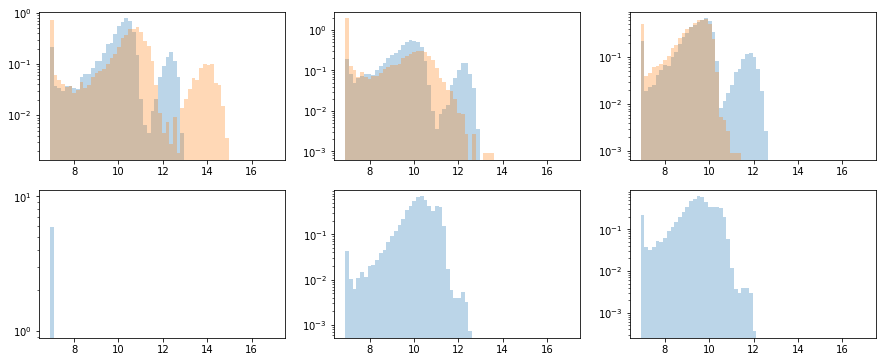

In [199]:
##Overlay optimized and non optimized
dataset_index = '0'
ch_index = 1

fluor_indices = [ch_index, 6, 7]

fig, ax = plt.subplots(2, 3, figsize=(15, 6))

for j in range(3):
    ax[0][j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, 
              histograms[dataset_index][fluor_indices[j]], width=bin_edges[1] - bin_edges[0], alpha=0.3)
    ax[0][j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, 
              histograms_ss_optimized[dataset_index][fluor_indices[j]], width=bin_edges[1] - bin_edges[0], alpha=0.3)
    ax[0][j].set_yscale('log')

for j in range(3):
    ax[1][j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, 
              histograms['9'][fluor_indices[j]], width=bin_edges[1] - bin_edges[0], alpha=0.3)
    ax[1][j].set_yscale('log')

# Export unmixed data without any fancy multi stain optimization

In [7]:
def do_inversion(prefix, markers, dataframe, inversion_model=6, **kwargs):
    #get indices of all data to invert
    to_use = all_data['slidescan_db'].query('(Batch == 1) or (Batch == 2)'.format(use_batch))
    dataset_indices = to_use['Index'].to_list()

    for dataset_index in dataset_indices:
        print('{}\r'.format(dataset_index), end='')
        row_mask = dataframe['dataset_index'] == dataset_index
    #     fluor_data = dataframe.loc[row_mask, channel_names].to_numpy()

        names = list(markers.values()) + ['autofluor_1', 'autofluor_2']
        names = [prefix + n for n in names]
        
        if inversion_model == 1:
            if dataset_index not in single_stain_multipliers.keys():
                continue
            inverted = invert_dataset(dataset_index, dataframe=dataframe, inversion_model=inversion_model,
                            multipliers=single_stain_multipliers[dataset_index], **kwargs)
        elif inversion_model == 0:
            inverted = invert_dataset(dataset_index, dataframe=dataframe,
                                      inversion_model=inversion_model, **kwargs)
        else:
            inverted = invert_dataset(dataset_index, dataframe=dataframe, 
                                      inversion_model=inversion_model, **kwargs)
        dataframe.loc[row_mask, names[:inverted.shape[1]]] = inverted
          
    
params =  {'init': 'nnsvda', 
                'beta_loss': 'kullback-leibler', 'solver': 'mu',
                'alpha': 1e-5, 
                'l1_ratio': 1,     
                'normalize': True}

    
params_noreg =  {'init': 'nnsvda', 
                'beta_loss': 'kullback-leibler', 'solver': 'mu',
                'alpha': 0, 
                'normalize': True}

# 0+2
do_inversion('unmixed_0+2_', inversion_model=0, autofluor=2, **params_noreg, **all_data)

# 1+2
do_inversion('unmixed_1+2_', inversion_model=1, autofluor=2, **params, **all_data)

# 6+2_ones
do_inversion('unmixed_6+2uniform_', multipliers=np.ones(8), autofluor=2, **params, **all_data)

# 6+2_noreg
do_inversion('unmixed_6+2noreg_', autofluor=2, **params_noreg, **all_data)

# 6+2_mean_af
af_only_multiplier = np.zeros(8)
af_only_multiplier[-2:] = np.mean(np.stack(list(single_stain_multipliers.values())), axis=0)[-2:]
do_inversion('unmixed_6+2mean_autofluor_', autofluor=2,
             multipliers=af_only_multiplier, **params, **all_data)

# 6+0_ones
do_inversion('unmixed_6+0uniform_', 
             multipliers=np.ones(8), autofluor=None, **params, **all_data)

# 6+0_no_reg
do_inversion('unmixed_6+0noreg_',
             multipliers=np.ones(8), autofluor=None, **params_noreg, **all_data)
    

In [9]:
##Write out data 

# all_data['dataframe']
home = str(Path.home())
new_name = home + '/leukosight_data/crops_record_FACS.csv'
all_data['dataframe'].to_csv(new_name, index=False)

# Multi-stain optimization

In [328]:
def plot_hists_with_targets(histograms, target_dist, cdf=False, **kwargs):

    fig, ax_row = plt.subplots(1, 8, figsize=(15, 3))

    for j in range(8):
#             if i == 0:
#                 ax_row[j].set_title((channel_names + ['autofluor1', 'auotfluor2'])[show_vec[j]])
        if j == 0:
#             ax_row[j].set_ylabel(name)
            pass
        else:
            ax_row[j].get_yaxis().set_visible(False)

        target_hist, bin_edges = np.histogram(target_dist[j], 60, (np.log(1e3), 17), density=True)
        if cdf:
            c1 = np.cumsum(histograms[j])
            c2 = np.cumsum(target_hist)
            ax_row[j].plot(c1)
            ax_row[j].plot(c2)
#             print('max absolute cdf diff {}'.format(np.max(np.abs(c1 - c2))))
#             ax_row[j].set_title('{:.2f}'.format(np.max(c1 - c2)))
        else:
            ax_row[j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, 
                          histograms[j], width=bin_edges[1] - bin_edges[0], alpha=0.3)
            ax_row[j].bar(bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2, 
                          target_hist, width=bin_edges[1] - bin_edges[0], alpha=0.3)
            ax_row[j].set_yscale('log')
            ax_row[j].set_ylim([1e-4, 1.6])

In [350]:
### Merge BV510 to get all target distributions
def merge_bv_510(unmixed_datasets, cd3_19_56_ds_indices, num_bins=100, cd3_cutoff_percentile=88.8, 
                 min_max=(np.log(1e3), 17)):
    #Computationally merge CD3, CD19, and CD56 into a sinlge dataset
    cd3, cd19, cd56 = [unmixed_datasets[int(a)] for a in cd3_19_56_ds_indices]

    cd3_densities = []
    cd19_densities = []
    cd56_densities = []
    for stain_index in np.arange(cd3.shape[1]):
        cd3_density, bin_edges = np.histogram(cd3[:, stain_index], num_bins, min_max, density=True)
        cd19_density, bin_edges = np.histogram(cd19[:, stain_index], num_bins, min_max, density=True)
        cd56_density, bin_edges = np.histogram(cd56[:, stain_index], num_bins, min_max, density=True)
        cd3_densities.append(cd3_density)
        cd19_densities.append(cd19_density)
        cd56_densities.append(cd56_density)
    bin_centers =  bin_edges[:-1] + np.diff(bin_edges) / 2
    
    cd3_densities = np.stack(cd3_densities, axis=0)
    cd19_densities = np.stack(cd19_densities, axis=0)
    cd56_densities = np.stack(cd56_densities, axis=0)
    
    cd3_densities /= np.sum(cd3_densities, axis=1)[:,None]
    cd19_densities /= np.sum(cd19_densities, axis=1)[:,None]
    cd56_densities /= np.sum(cd56_densities,axis=1)[:,None]
    
#     plt.hist(cd3, bins=bin_edges, alpha=0.4, density=True)
#     plt.hist(cd19, bins=bin_edges, alpha=0.4, density=True)
#     plt.hist(cd56, bins=bin_edges, alpha=0.4, density=True)

    threshold = np.percentile(cd3[:, 1], cd3_cutoff_percentile)
    positive_densities = np.sum(np.stack([pop[bin_edges[:-1] > threshold] for pop in 
                                        [cd3_densities[1], cd19_densities[1], cd56_densities[1]]], axis=0), axis=0)
    negative_densities = np.sum(np.stack([pop[bin_edges[:-1] < threshold] for pop in 
                                        [cd3_densities[1], cd19_densities[1], cd56_densities[1]]], axis=0), axis=0)
    negative_densities = (negative_densities / np.sum(negative_densities)) * (1 - np.sum(positive_densities))
    new_densities = np.concatenate([negative_densities, positive_densities])
    
#     plt.bar(bin_centers, new_density, width=bin_centers[1] - bin_centers[0])
    channel_1_cdf = np.cumsum(new_densities)

    mean_densities = np.mean(np.stack([cd3_densities, cd19_densities, cd56_densities], axis=0), axis=0)

    all_cdfs = np.cumsum(mean_densities, axis=1)
    all_cdfs[1] = channel_1_cdf
    empty_channels = [0,2,3,4,5]
    
    num_random = 10000
    random_from_cdf = np.zeros((num_random, all_cdfs.shape[0]))
    for stain_index in np.arange(all_cdfs.shape[0]):
        if stain_index in empty_channels:
            random_from_cdf[:, stain_index] = min_max[0]
        else:
            values = np.random.rand(10000)
            inv_cdf = interpolate.interp1d(np.concatenate([np.array([0]), all_cdfs[stain_index]]), bin_edges)
            random_from_cdf[:, stain_index] = inv_cdf(np.random.rand(num_random))   

# # #     plt.hist(random_from_cdf, bins=bin_edges, alpha=0.4, density=True)
    
    return random_from_cdf


##Single stain datasets inverted with optimal parameters

batch_index = 1
slidescan_db = all_data['slidescan_db']
single_and_unstained_db = slidescan_db.query('(Batch == {}) and (Stain != \'all\')'.format(batch_index))
bv510_indices = slidescan_db.query('(Batch == {}) and (Stain == \'BV510\')'.format(batch_index))['Index'].to_list()
bv510_indices = [str(x) for x in bv510_indices]

inversion_params =  {'init': 'nnsvda', 
                'beta_loss': 'kullback-leibler', 'solver': 'mu',
                'alpha': 1e-5, 
                'l1_ratio': 1,     
                'normalize': True,
                'autofluor': 2}
inverted_datasets = {}
for dataset_index in single_and_unstained_db['Index'].to_list():
    if single_and_unstained_db.loc[dataset_index]['Stain'] == 'unstained':
        multipliers = np.ones(8)
    else:
        multipliers = single_stain_multipliers[dataset_index]
    inverted_datasets[dataset_index] = invert_dataset(dataset_index, 
                                multipliers=multipliers, **inversion_params, **all_data)

    
##Target distributions to optmize multi stain unmixing to
    
#Merge to BV510 datasets
cd3_19_56_ds_indices = bv510_indices #TODO ACTUALLY READ INDICES FOR EACH STAIN CAUSE NOT ORDERED ON BATCH 2
random_from_cdf = merge_bv_510(inverted_datasets, cd3_19_56_ds_indices=cd3_19_56_ds_indices)

inverted_datasets['BV510_merge'] = random_from_cdf
# for ind in bv510_indices:
#     del inverted_datasets[int(ind)]

# histograms, bin_edges = compute_histograms(inverted_datasets)
# plot_hists(histograms, show_vec=[0,1,2,3,4,5,6,7], **all_data)

# make target distributions to optimize to
target_distributions = {}
for key in inverted_datasets.keys():
    if key == 'BV510_merge':
        target_distributions[1] = inverted_datasets['BV510_merge'][:,1]
    elif single_and_unstained_db.loc[key]['Stain'] == 'unstained':
        target_distributions[6] = inverted_datasets[key][:, 6]
        target_distributions[7] = inverted_datasets[key][:, 7]
    else:
        fluor_index = all_data['channel_names'].index(single_and_unstained_db.loc[key]['Stain'])
        if fluor_index == 1:
            continue #this is the BV510 one
        target_distributions[fluor_index] = inverted_datasets[key][:, fluor_index]
#reorder
target_distributions = {k: target_distributions[k] for k in set(target_distributions.keys()) }


In [454]:
def multi_single_stain_invert_and_score(params_list,  reference_unmixed, slidescan_db,
                                 min_max=(np.log(1e3), 17), batch_index = 1, **kwargs):
    batch_db = slidescan_db.query('Batch == {}'.format(batch_index))
    single_stain_db = batch_db[~batch_db['Stain'].isin(['all', 'unstained'])]
    unstained_dataset_indices = batch_db[batch_db['Stain'].isin(['unstained'])]['Index'].to_list()
    dataset_indices = single_stain_db['Index'].to_list()
    single_stain_data = {dataset_index: prepare_dataset(dataset_index, slidescan_db=slidescan_db, 
                                                   **kwargs)[0] for dataset_index in dataset_indices}
    unstained_data =prepare_dataset(unstained_dataset_indices[0], slidescan_db=slidescan_db, **kwargs)[0]
        
    scores = []
    for params in params_list:
        
        distance = 0
        for dataset_index in single_stain_data.keys(): #iterate through every single stain dataset
            unmixed = do_nnmf(single_stain_data[dataset_index], 'all', min_max=min_max, **params, **kwargs)
            stain_name = single_stain_db.loc[dataset_index, 'Stain'] 
            stain_index = channel_names.index(stain_name)
#             dd = dist_dist(reference_unmixed[dataset_index][:, stain_index],
#                                                unmixed[:, stain_index])
            distance += dist_dist(reference_unmixed[9][:, 6], unmixed[:, 6])
            distance += dist_dist(reference_unmixed[9][:, 6], unmixed[:, 6])
#             if stain_name == 'BV510':
#                 dd /= 3
#             distance += dd
            
        af_unmixed = do_nnmf(unstained_data, 'all', min_max=min_max, **params, **kwargs)
        
        distance += dist_dist(af_unmixed[:, 6], reference_unmixed[9][:, 6])
        distance += dist_dist(af_unmixed[:, 7], reference_unmixed[9][:, 7])
        
        scores.append(distance)
    
    return scores


In [455]:
### Attempt to find parameters that match single-stain datasets under multi-stain model
# to target distributions of single stains serived from single model

def optimize_multi_single_stain_multipliers( slidescan_db, channel_names, use_batch=1, min_max=(np.log(1e3), 17), **kwargs):
      
    
    ##### Coordinate descent
    multiplier_master = np.ones(8) 
    threads = 25
    search_space_log = 1
    num_search_vals = 50


    for iteration in range(10000):
        
        search_space_log *= 0.95
        print('new log search space {}'.format(search_space_log))
        ##Optmize each stain

        for ii in range(100):
#             fluor_index = ii % 8
            fluor_index = np.random.choice(np.array([6, 7]))
         
            
            multipliers = np.stack(num_search_vals * [multiplier_master], axis=0)
                        
            stain_mult_vals =  np.logspace(np.log10(multiplier_master[fluor_index]) - search_space_log, 
                                           np.log10(multiplier_master[fluor_index]) + search_space_log, num_search_vals)
           
            multipliers[:, fluor_index] = stain_mult_vals
            
            param_list = []
            for k in range(multipliers.shape[0]):
                params = {}
                params['init'] = 'nnsvda'
                params['beta_loss'] = 'kullback-leibler'
                params['alpha'] = 1e-5
                params['l1_ratio'] = 1
                params['multipliers'] = multipliers[k]
                params['autofluor'] = 2
                params['normalize'] = True
                params['solver'] = 'mu'
                param_list.append(params)
            
                
            param_list_chunked = []
            n = num_search_vals // threads
            for j in range(0, len(param_list), n):  
                param_list_chunked.append(param_list[j:j + n])
                
#             replicate_scores = []
#             for batch in param_list_chunked:
#                 replicate_scores.append(multi_single_stain_invert_and_score(batch, inverted_datasets, **all_data))
            
            replicate_scores = Parallel(n_jobs=threads, prefer='processes', verbose=0)(
                delayed(multi_single_stain_invert_and_score)(batch, inverted_datasets, 
                                                             **all_data) for batch in param_list_chunked)
            replicate_scores = np.ravel(np.array(replicate_scores))
    
            #take a step for the one being minimized
            best_index = np.argmin(replicate_scores)
            multiplier_master = multipliers[best_index]
            print('fluor index {} \t score = {:.5} \t {}'.format(
                fluor_index, replicate_scores[best_index], ', '.join(
                    ['{:.2}'.format(x) for x in multiplier_master])))
                     
#             if ii % 10 == 0:
#             print(multiplier_master)
            
        

optimize_multi_single_stain_multipliers(**all_data)

new log search space 0.95
fluor index 6 	 score = 17.744 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.5, 1.0
fluor index 7 	 score = 17.676 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.5, 0.43
fluor index 7 	 score = 17.671 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.5, 0.45
fluor index 6 	 score = 17.492 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.7e+01, 0.45
fluor index 7 	 score = 17.482 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.7e+01, 0.51
fluor index 7 	 score = 17.48 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.7e+01, 0.54
fluor index 7 	 score = 17.482 	 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.7e+01, 0.51


KeyboardInterrupt: 

baselin 0.4336852475314821
optmized 0.46665470275122917


Text(0.5, 1.0, 'optmized')

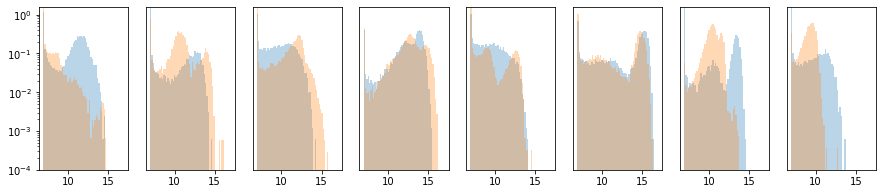

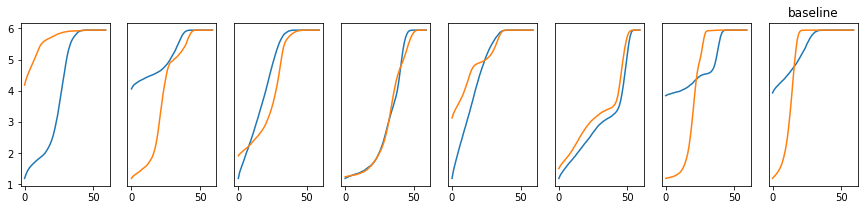

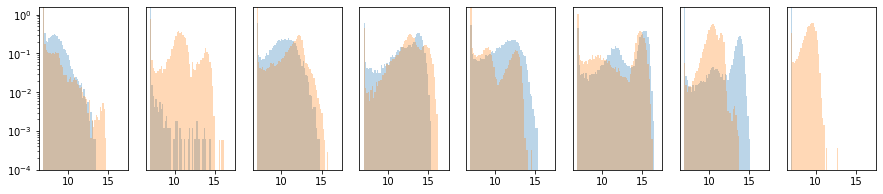

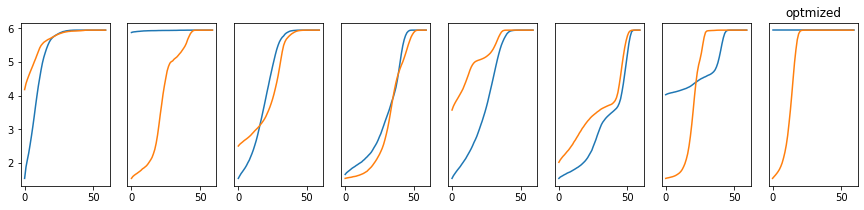

In [417]:
best_params =  {'init': 'nnsvda', 
                'beta_loss': 'kullback-leibler', 'solver': 'mu',
                'alpha': 1e-5, 
                'l1_ratio': 1,     
                'normalize': True,
                'autofluor': 2}

def hist_it_and_show(unmixed_datasets, dataset_to_show_index):
    histograms_unmixed, bin_edges = compute_histograms(unmixed_datasets)
    plot_hists_with_targets(histograms_unmixed[dataset_to_show_index], target_distributions, cdf=False, 
                             **all_data)
    plot_hists_with_targets(histograms_unmixed[dataset_to_show_index], target_distributions, cdf=True,
                            **all_data)

    
unmixed_datasets = {}

# TODO: some optimized multipliers
opt_mult = np.array([0.18, 0.02, 1.9, 0.22, 6.2, 1.6, 1.3e+01, 0.014])

unmixed_datasets['12'] = invert_dataset(12, multipliers=opt_mult,
                                        **best_params, **all_data)
unmixed_datasets['9'] = invert_dataset(9, multipliers=np.ones(8), 
                                               **best_params, **all_data)
#baseline--no multipliers
unmixed_datasets['12_baseline'] = invert_dataset(12, multipliers=np.ones(8), 
                                        **best_params, **all_data)

test_ch = 2
print('baseline', dist_dist(unmixed_datasets['12_baseline'][:, test_ch], target_distributions[test_ch]))
print('optmized', dist_dist(unmixed_datasets['12'][:, test_ch], target_distributions[test_ch]))
        

hist_it_and_show(unmixed_datasets, '12_baseline')
plt.title('baseline')
hist_it_and_show(unmixed_datasets, '12')
plt.title('optmized')

# for dataset_index in single_stain_multipliers.keys():
#     unmixed_datasets['{}'.format(dataset_index)] = invert_dataset(dataset_index, 
#             multipliers=single_stain_multipliers[dataset_index], **best_params, **all_data)

# dataset_to_show_index = '12'



## Visualize unmixed data

In [81]:
@interact
def scatter_plot(x=channel_names, y=channel_names[1:], dataset_index=data_ids):    

    mask = (dataframe['dataset_index'] == dataset_index).to_numpy()

    x_index = channel_names.index(x)
    y_index = channel_names.index(y)
    
    x_data = unmixed[x_index][mask]
    y_data = unmixed[y_index][mask]
    
    x_data = np.log(x_data)
    y_data = np.log(y_data) 

    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)
    
    plt.figure(figsize=(8,8))
    plt.scatter(x_data, y_data, c=z, s=20, cmap='inferno')
#     plt.scatter(x_data, y_data)
#     plt.hist(x_data, 100, log=True)
    
    plt.xlabel(x + ' ' + markers[x])
    plt.ylabel(y + ' ' + markers[y])

interactive(children=(Dropdown(description='x', options=('BV421', 'BV510', 'BV570', 'BV605', 'BV650', 'BV711')…